<a href="https://colab.research.google.com/github/SeyfGoumeida/Supervised_Learning_Cora_Citeseed_PubMed/blob/main/Projet_%C2%AB_Apprentissage_supervis%C3%A9_%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prérequirement :
- Imbalanced-Learn Library
- Stellargraph (Cora)

In [ ]:
!sudo pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#KNN
from sklearn.neighbors import KNeighborsClassifier
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#QDA
import sklearn.discriminant_analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#LR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
#CART
from sklearn import tree
#RF
from sklearn.ensemble import RandomForestClassifier

#---------------- fonction afficher resultat -----------------
def afficher_resultat(result):
  print("--------------------------")
  print("Unbalanced - | -  Balanced ")
  print("--------------------------")

  for i in result: 
    algo,unbalance,balance=i
    unbalance = "{0:.0f}%".format(unbalance* 100)
    balance = "{0:.0f}%".format(balance* 100)
    print(algo, ":")
    print(unbalance,"        |        ",balance)
    print("--------------------------")

#---------------- fonction comparaison des resultats -----------------
def comparer_resultat(result1,result2):
  for i in range(0,len(result1)): 
    algo,unbalance1,balance1=result1[i]
    algo,unbalance2,balance2=result2[i]

    unbalance2 = "{0:.0f}%".format(unbalance2* 100)
    balance2 = "{0:.0f}%".format(balance2* 100)
    unbalance1 = "{0:.0f}%".format(unbalance1* 100)
    balance1 = "{0:.0f}%".format(balance1* 100)

    print(algo, " :")
    print("            Unbalanced    |      Balanced ")
    print("---------------------------------------------")
    print("Resultat X : ",unbalance1,"        |        ",balance1)
    print("Resultat M : ",unbalance2,"        |        ",balance2)
    print("---------------------------------------------")
#------------------------------------------------
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None
#------------------------------------------------ 
import pandas as pd
import os
import numpy as np
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter


     |████████████████████████████████| 374 kB 15.3 MB/s 
     |████████████████████████████████| 482 kB 64.1 MB/s 
     |████████████████████████████████| 41 kB 673 kB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#1 - Données Crédits bancaires :

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv',header=None)
df.rename({0: "Statut du compte courant existant", 1:"Durée en mois",2: "Historique de crédit",3: "Objectif",
           4:"Montant du crédit", 5:"Compte d'épargne", 6:"Emploi actuel depuis", 7:"Taux de versement en",
           8:"pourcentage du revenu disponible", 9:"Statut personnel et sexe",10: "Autres débiteurs",
           11:"Résidence actuelle depuis",12:"Propriété", 13:"Age en années", 14:"Autres plans de versement", 
           15:"Logement",16:"Nombre de crédits existants dans cette banque", 17:"Travail",
           18:"Nombre de personnes à charge", 19:"Téléphone", 20:"Travailleur étranger"}, axis='columns')

,Statut du compte courant existant,Durée en mois,Historique de crédit,Objectif,Montant du crédit,Compte d'épargne,Emploi actuel depuis,Taux de versement en,pourcentage du revenu disponible,Statut personnel et sexe,Autres débiteurs,Résidence actuelle depuis,Propriété,Age en années,Autres plans de versement,Logement,Nombre de crédits existants dans cette banque,Travail,Nombre de personnes à charge,Téléphone,Travailleur étranger
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201,2


#2 - Données relationnelles :

## I- CORA:

### Loading Data :

In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)


In [ ]:
print("- La taille du réseau de citations (The citation network) : ",len(G.edges()))
print("- Format du réseau de citations : paper-cites->paper")
print("- Exemple sur une publication et une partie de ses liens :" )
for i in range(0,10):
  print(G.edges()[i])

- La taille du réseau de citations (The citation network) :  5429
- Format du réseau de citations : paper-cites->paper
- Exemple sur une publication et une partie de ses liens :
(1033, 35)
(103482, 35)
(103515, 35)
(1050679, 35)
(1103960, 35)
(1103985, 35)
(1109199, 35)
(1112911, 35)
(1113438, 35)
(1113831, 35)


In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support.

<Figure size 720x216 with 0 Axes>

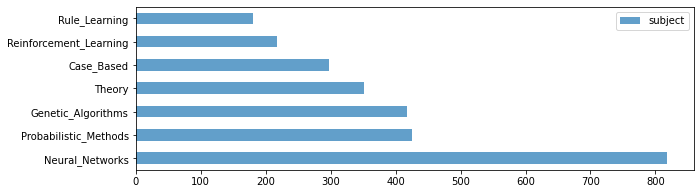

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10,3)
a = node_subjects.value_counts().to_frame()
plt.figure()
a.plot(kind="barh",alpha=0.7)


 Pie plot :


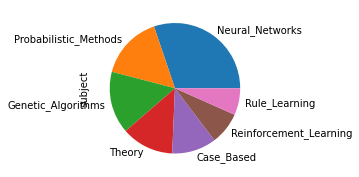

In [ ]:
print(" Pie plot :")
plt.figure()
a["subject"].plot(kind="pie")

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)

sampling_strategy='minority' => This means that if the majority class had 1,000 examples and the minority class had 100, this strategy would oversampling the minority class so that it has 1,000 examples.

sampling_strategy=0.5 => This would ensure that the minority class was oversampled to have half the number of examples as the majority class, for binary classification problems. This means that if the majority class had 1,000 examples and the minority class had 100, the transformed dataset would have 500 examples of the minority class.




In [ ]:
edge_list = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
edge_list["label"] = "cites"
display(edge_list.head(10))


,target,source,label
0,35,1033,cites
1,35,103482,cites
2,35,103515,cites
3,35,1050679,cites
4,35,1103960,cites
5,35,1103985,cites
6,35,1109199,cites
7,35,1112911,cites
8,35,1113438,cites
9,35,1113831,cites


In [ ]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_list = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.content"),
    sep="\t",
    header=None,
    names=column_names,
)


In [ ]:
node_list.head(5)


,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_1394,w_1395,w_1396,w_1397,w_1398,w_1399,w_1400,w_1401,w_1402,w_1403,w_1404,w_1405,w_1406,w_1407,w_1408,w_1409,w_1410,w_1411,w_1412,w_1413,w_1414,w_1415,w_1416,w_1417,w_1418,w_1419,w_1420,w_1421,w_1422,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [ ]:
# gather all features into lists under 'features' column.
node_list["features"] = node_list[feature_names].values.tolist()

node_list = node_list.drop(columns=feature_names)
node_list["id"] = node_list.index
node_list.head(5)


,subject,features,id
31336,Neural_Networks,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",31336
1061127,Rule_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1061127
1106406,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1106406
13195,Reinforcement_Learning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13195
37879,Probabilistic_Methods,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37879


In [ ]:
#The different subjects are:
set(node_list["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### 1. Uniquement l’information contenue dans la matrice  X :

In [ ]:
X = np.array(list(node_list['features']))
y = np.array(list(node_list['subject']))
resultat_1 = []
resultat_2 = []

#### Data Balancing :

Avant Data Balancing : 
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64



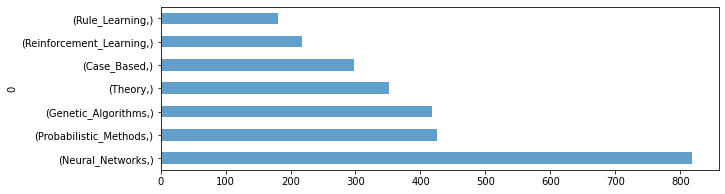

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)


Aprés Data Balancing : 
Theory                    818
Rule_Learning             818
Reinforcement_Learning    818
Probabilistic_Methods     818
Neural_Networks           818
Genetic_Algorithms        818
Case_Based                818
dtype: int64



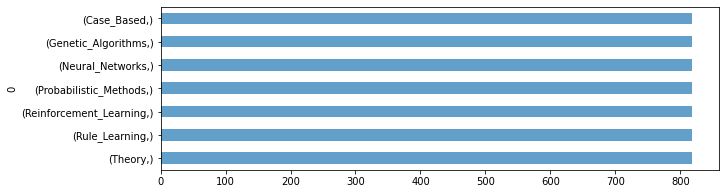

In [ ]:
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(X,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y_train_balanced).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)

#### Data split :

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [ ]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

[2 5 4 ... 1 0 2]


#### Gaussian Naive Bayes :

In [ ]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


Number of mislabeled points out of a total 542 points : 261
Accuracy: 0.518450184501845


With balanced data :

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Gaussian Naive Bayes",res1,res2))


Number of mislabeled points out of a total 1146 points : 243
Accuracy: 0.7879581151832461


#### KNN :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 302
Accuracy: 0.44280442804428044


With balanced data :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("KNN",res1,res2))

Number of mislabeled points out of a total 1146 points : 260
Accuracy: 0.7731239092495636


#### LDA : 

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 200
Accuracy: 0.6309963099630996


With balanced data :

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LDA",res1,res2))

Number of mislabeled points out of a total 1146 points : 135
Accuracy: 0.8821989528795812


#### QDA :

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 542 points : 463
Accuracy: 0.14575645756457564


In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("QDA",res1,res2))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 1146 points : 138
Accuracy: 0.8795811518324608


#### Linear SVM :

#### Linear SVM ( non linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 148
Accuracy: 0.7269372693726938


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("NON Linear SVM",res1,res2))

Number of mislabeled points out of a total 1146 points : 141
Accuracy: 0.8769633507853403


#### Linear SVM ( linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 179
Accuracy: 0.6697416974169742


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Linear SVM",res1,res2))

Number of mislabeled points out of a total 1146 points : 82
Accuracy: 0.9284467713787086


#### LR :

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 131
Accuracy: 0.7583025830258303


In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LR",res1,res2))

Number of mislabeled points out of a total 1146 points : 64
Accuracy: 0.944153577661431


#### CART :

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 204
Accuracy: 0.6236162361623616


In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("CART",res1,res2))

Number of mislabeled points out of a total 1146 points : 103
Accuracy: 0.9101221640488656


#### Random Forest:

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 141
Accuracy: 0.7398523985239852


In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Random Forest",res1,res2))

Number of mislabeled points out of a total 1146 points : 53
Accuracy: 0.9537521815008726


#### Resultat : 

In [ ]:
afficher_resultat(resultat_1)

--------------------------
Unbalanced - | -  Balanced 
--------------------------
Gaussian Naive Bayes :
52%         |         79%
--------------------------
KNN :
44%         |         77%
--------------------------
LDA :
63%         |         88%
--------------------------
QDA :
15%         |         88%
--------------------------
NON Linear SVM :
73%         |         88%
--------------------------
Linear SVM :
67%         |         93%
--------------------------
LR :
76%         |         94%
--------------------------
CART :
62%         |         91%
--------------------------
Random Forest :
74%         |         95%
--------------------------


### 2. Une Combinaison des informations W et X tel que M=D^(-1)*W*X : 

#### Matrice W :

W: la matrice d’adjacence (des liens entre les individus) W(n,n)

In [ ]:
W = pd.DataFrame()
list_individus = list(node_list.index)
W = pd.DataFrame(index =list_individus,columns=list_individus)  

#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(df_matrix, value=0): 
    df_matrix = df_matrix.fillna(0)
    mat = df_matrix.values
    n = mat.shape[0]
    mat[range(n), range(n)] = value
    return pd.DataFrame(mat,index =list_individus,columns=list_individus)

W = pd_fill_diagonal(W,1)

# #---------- Les liens entre les individus ----------------

def pd_fill_edges(df_matrix): 
  mat = df_matrix.values
  n = mat.shape[0]
  columns = df_matrix.columns
  indexes = df_matrix.index
  egdes = G.edges()
  for i in egdes : 
    r , c = i
    df_matrix.at[r,c] = 1
    df_matrix.at[c,r] = 1

  df_matrix = df_matrix.fillna(0)

  return df_matrix
W = pd_fill_edges(W)

# ------------   print --------------------
W

,31336,1061127,1106406,13195,37879,1126012,1107140,1102850,31349,1106418,1123188,1128990,109323,217139,31353,32083,1126029,1118017,49482,753265,249858,1113739,48766,646195,1126050,59626,340299,354004,242637,1106492,74975,1152272,100701,66982,13960,13966,66990,182093,182094,13972,...,616336,1120252,1152958,1152959,1385,254923,34961,46547,13136,1131137,233106,561613,1131149,1104258,1152991,447250,115188,102879,1131150,56708,1128943,134060,102884,1131163,4274,1131172,767763,152226,152227,626530,626531,1131180,1130454,1131184,1128974,1128975,1128977,1128978,117328,24043
31336,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1106406,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
117328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#---------- Verification de l'individus 35 ----------------

verif = []
l = W.loc[35]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print(verif)
print(G.edges())

[35, 887, 1033, 1688, 1956, 8865, 12576, 15670, 18582, 27510, 28290, 28851, 33904, 33907, 35061, 38205, 41714, 44368, 45599, 46079, 46431, 48766, 54129, 54131, 56119, 66556, 66563, 66805, 69284, 69296, 78511, 81722, 82098, 82920, 84021, 85352, 86359, 97645, 98698, 103482, 103515, 116552, 128540, 132806, 135130, 141342, 141347, 148170, 175291, 178727, 190697, 190706, 197054, 198443, 198653, 206371, 210871, 210872, 229635, 231249, 248425, 249421, 254923, 259701, 259702, 263279, 263498, 265203, 273152, 286500, 287787, 289779, 289780, 289781, 307015, 335733, 387795, 415693, 427606, 486840, 503883, 503893, 513189, 561238, 568857, 573964, 573978, 574009, 574264, 574462, 575077, 575292, 575331, 576725, 576795, 577227, 578780, 579008, 592973, 593091, 593105, 593240, 593260, 593813, 594047, 594543, 594649, 594900, 608326, 634902, 634904, 634938, 634975, 640617, 646809, 646837, 647408, 647447, 694759, 735303, 787016, 801170, 1050679, 1103960, 1103985, 1109199, 1112911, 1113438, 1113831, 1114331,

#### Matrice D et D^-1:

D est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne de W

In [ ]:
D = pd.DataFrame()
D = pd.DataFrame(index =range(0,len(list_individus)),columns=range(0,len(list_individus))) 


#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(d,w): 
    mat = d.values
    n = mat.shape[0]
    mat[range(n), range(n)] = w.sum(axis=1)
    df_matrix = pd.DataFrame(mat,index =list_individus,columns=list_individus)
    df_matrix = df_matrix.fillna(0)
    return df_matrix

D = pd_fill_diagonal(D,W)
#------------------ D^-1 --------------------------
D_1 = 1/D
D_1.replace([np.inf, -np.inf], np.nan, inplace=True)
D_1.fillna(0,inplace=True)
D

,31336,1061127,1106406,13195,37879,1126012,1107140,1102850,31349,1106418,1123188,1128990,109323,217139,31353,32083,1126029,1118017,49482,753265,249858,1113739,48766,646195,1126050,59626,340299,354004,242637,1106492,74975,1152272,100701,66982,13960,13966,66990,182093,182094,13972,...,616336,1120252,1152958,1152959,1385,254923,34961,46547,13136,1131137,233106,561613,1131149,1104258,1152991,447250,115188,102879,1131150,56708,1128943,134060,102884,1131163,4274,1131172,767763,152226,152227,626530,626531,1131180,1130454,1131184,1128974,1128975,1128977,1128978,117328,24043
31336,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1106406,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0
117328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0


In [ ]:
#---------- Verification de D sur l'individus 31336 & 1061127 ----------------
verif = []
l = W.loc[31336]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print("l'individus 31336   : ",len(verif)," liens ")
#------------------------------------------------------------------------------
verif = []
l = W.loc[1061127]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print("l'individus 1061127 : ",len(verif)," liens ")

l'individus 31336   :  6  liens 
l'individus 1061127 :  2  liens 


In [ ]:
D_1

,31336,1061127,1106406,13195,37879,1126012,1107140,1102850,31349,1106418,1123188,1128990,109323,217139,31353,32083,1126029,1118017,49482,753265,249858,1113739,48766,646195,1126050,59626,340299,354004,242637,1106492,74975,1152272,100701,66982,13960,13966,66990,182093,182094,13972,...,616336,1120252,1152958,1152959,1385,254923,34961,46547,13136,1131137,233106,561613,1131149,1104258,1152991,447250,115188,102879,1131150,56708,1128943,134060,102884,1131163,4274,1131172,767763,152226,152227,626530,626531,1131180,1130454,1131184,1128974,1128975,1128977,1128978,117328,24043
31336,0.166667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00
1061127,0.000000,0.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00
1106406,0.000000,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00
13195,0.000000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00
37879,0.000000,0.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.0,0.00
1128977,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.333333,0.0,0.0,0.00
1128978,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.2,0.0,0.00
117328,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.2,0.00


#### M :

M=D^(-1)WX : (n,n)*(n,n)*(n,d) => (n,d)

In [ ]:
M = D_1.dot(W)
M = M.dot(X)
M

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
31336,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.166667,0.0,0.166667,0.166667,0.00,0.00,0.0,0.0,0.0,0.0
1061127,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.500000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0
1106406,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0
13195,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.000000,0.00,0.25,0.0,0.0,0.0,0.0
37879,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.25,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0
1128977,0.0,0.0,0.333333,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0
1128978,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.200000,0.0,0.000000,0.000000,0.20,0.00,0.0,0.0,0.0,0.0
117328,0.0,0.0,0.200000,0.0,0.6,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.0,0.0,0.00,0.00,...,0.2,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.200000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0


#### Data Balancing :

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(M,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())

Avant Data Balancing : 
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

Aprés Data Balancing : 
Theory                    818
Rule_Learning             818
Reinforcement_Learning    818
Probabilistic_Methods     818
Neural_Networks           818
Genetic_Algorithms        818
Case_Based                818
dtype: int64


#### Data split :

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [ ]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

[2 5 4 ... 1 0 2]


#### Gaussian Naive Bayes :

In [ ]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


Number of mislabeled points out of a total 542 points : 108
Accuracy: 0.8007380073800738


With balanced data :

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Gaussian Naive Bayes",res1,res2))


Number of mislabeled points out of a total 1146 points : 102
Accuracy: 0.9109947643979057


#### KNN :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 89
Accuracy: 0.8357933579335793


With balanced data :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("KNN",res1,res2))

Number of mislabeled points out of a total 1146 points : 63
Accuracy: 0.9450261780104712


#### LDA : 

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 115
Accuracy: 0.7878228782287823


With balanced data :

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LDA",res1,res2))

Number of mislabeled points out of a total 1146 points : 67
Accuracy: 0.9415357766143106


#### QDA :

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 542 points : 298
Accuracy: 0.45018450184501846


In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("QDA",res1,res2))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 1146 points : 59
Accuracy: 0.9485165794066318


#### Linear SVM :

#### Linear SVM ( non linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 72
Accuracy: 0.8671586715867159


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("NON Linear SVM",res1,res2))

Number of mislabeled points out of a total 1146 points : 88
Accuracy: 0.9232111692844677


#### Linear SVM ( linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 94
Accuracy: 0.8265682656826568


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Linear SVM",res1,res2))

Number of mislabeled points out of a total 1146 points : 42
Accuracy: 0.9633507853403142


#### LR :

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 69
Accuracy: 0.8726937269372693


In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LR",res1,res2))

Number of mislabeled points out of a total 1146 points : 50
Accuracy: 0.956369982547993


#### CART :

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 140
Accuracy: 0.7416974169741697


In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("CART",res1,res2))

Number of mislabeled points out of a total 1146 points : 64
Accuracy: 0.944153577661431


#### Random Forest:

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 542 points : 81
Accuracy: 0.8505535055350554


In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Random Forest",res1,res2))

Number of mislabeled points out of a total 1146 points : 33
Accuracy: 0.9712041884816754


#### Resultat : 

In [ ]:
afficher_resultat(resultat_2)

--------------------------
Unbalanced - | -  Balanced 
--------------------------
Gaussian Naive Bayes :
80%         |         91%
--------------------------
KNN :
84%         |         95%
--------------------------
LDA :
79%         |         94%
--------------------------
QDA :
45%         |         95%
--------------------------
NON Linear SVM :
87%         |         92%
--------------------------
Linear SVM :
83%         |         96%
--------------------------
LR :
87%         |         96%
--------------------------
CART :
74%         |         94%
--------------------------
Random Forest :
85%         |         97%
--------------------------


### Comparaison des resultats de X et de M : 

In [ ]:
comparer_resultat(resultat_1,resultat_2)

Gaussian Naive Bayes  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  52%         |         79%
Resultat M :  80%         |         91%
---------------------------------------------
KNN  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  44%         |         77%
Resultat M :  84%         |         95%
---------------------------------------------
LDA  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  63%         |         88%
Resultat M :  79%         |         94%
---------------------------------------------
QDA  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  15%         |         88%
Resultat M :  45%         |         95%
---------------------------------------------
NON Linear SVM  :
            Unbalanced    |      Balanced 
----------------------------------

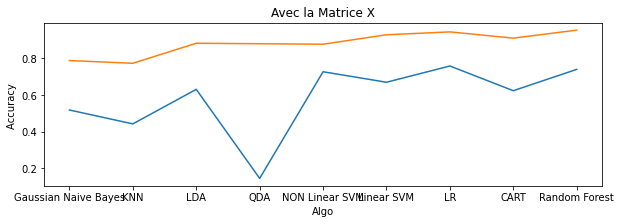

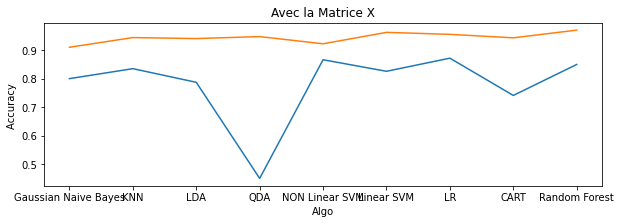

In [ ]:
plt.title('Avec la Matrice X')
plt.xlabel('Algo')
plt.ylabel('Accuracy ')
plt.plot(*zip(*resultat_1))
plt.show()

print()

plt.title('Avec la Matrice X')
plt.xlabel('Algo')
plt.ylabel('Accuracy ')
plt.plot(*zip(*resultat_2))
plt.show()

## II - CiteSeer


### Loading Data :

In [ ]:
from stellargraph import datasets

dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print("- La taille du réseau de citations (The citation network) : ",len(G.edges()))
print("- Format du réseau de citations : paper-cites->paper")
print("- Exemple sur une publication et une partie de ses liens :" )
for i in range(0,10):
  print(G.edges()[i])

- La taille du réseau de citations (The citation network) :  4715
- Format du réseau de citations : paper-cites->paper
- Exemple sur une publication et une partie de ses liens :
('100157', '100157')
('364207', '100157')
('38848', '100157')
('bradshaw97introduction', '100157')
('bylund99coordinating', '100157')
('dix01metaagent', '100157')
('gray99finding', '100157')
('labrou01standardizing', '100157')
('labrou99agent', '100157')
('nodine98overview', '100157')


In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)


In [ ]:
node_subjects.value_counts().to_frame()

,subject
DB,701
IR,668
Agents,596
ML,590
HCI,508
AI,249


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support.

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)



sampling_strategy='minority' => This means that if the majority class had 1,000 examples and the minority class had 100, this strategy would oversampling the minority class so that it has 1,000 examples.

sampling_strategy=0.5 => This would ensure that the minority class was oversampled to have half the number of examples as the majority class, for binary classification problems. This means that if the majority class had 1,000 examples and the minority class had 100, the transformed dataset would have 500 examples of the minority class.




In [ ]:
node_subjects

100157                  Agents
100598                      IR
105684                  Agents
11099                       DB
114091                      AI
                         ...  
zhang99query                DB
zhang99situated             ML
zhang99towards              IR
zhou00implementation        DB
455346                      ML
Name: subject, Length: 3312, dtype: object

In [ ]:
edge_list = pd.read_csv(
    os.path.join(dataset.data_directory, "citeseer.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
edge_list["label"] = "cites"
display(edge_list.head(10))


,target,source,label
0,100157,100157,cites
1,100157,364207,cites
2,100157,38848,cites
3,100157,bradshaw97introduction,cites
4,100157,bylund99coordinating,cites
5,100157,dix01metaagent,cites
6,100157,gray99finding,cites
7,100157,labrou01standardizing,cites
8,100157,labrou99agent,cites
9,100157,nodine98overview,cites


In [ ]:
feature_names = ["w_{}".format(ii) for ii in range(3703)]
column_names = feature_names + ["subject"]
node_list = pd.read_csv(
    os.path.join(dataset.data_directory, "citeseer.content"),
    sep="\t",
    header=None,
    names=column_names,
)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
node_list

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_3664,w_3665,w_3666,w_3667,w_3668,w_3669,w_3670,w_3671,w_3672,w_3673,w_3674,w_3675,w_3676,w_3677,w_3678,w_3679,w_3680,w_3681,w_3682,w_3683,w_3684,w_3685,w_3686,w_3687,w_3688,w_3689,w_3690,w_3691,w_3692,w_3693,w_3694,w_3695,w_3696,w_3697,w_3698,w_3699,w_3700,w_3701,w_3702,subject
100157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agents
100598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IR
105684,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agents
11099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,DB
114091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhang99query,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,DB
zhang99situated,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ML
zhang99towards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,IR
zhou00implementation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,DB


In [ ]:
node_list.head(5)


,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_3664,w_3665,w_3666,w_3667,w_3668,w_3669,w_3670,w_3671,w_3672,w_3673,w_3674,w_3675,w_3676,w_3677,w_3678,w_3679,w_3680,w_3681,w_3682,w_3683,w_3684,w_3685,w_3686,w_3687,w_3688,w_3689,w_3690,w_3691,w_3692,w_3693,w_3694,w_3695,w_3696,w_3697,w_3698,w_3699,w_3700,w_3701,w_3702,subject
100157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agents
100598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,IR
105684,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agents
11099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,DB
114091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AI


In [ ]:
# gather all features into lists under 'features' column.
node_list["features"] = node_list[feature_names].values.tolist()

node_list = node_list.drop(columns=feature_names)
node_list["id"] = node_list.index
node_list.head(5)


,subject,features,id
100157,Agents,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",100157
100598,IR,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",100598
105684,Agents,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",105684
11099,DB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11099
114091,AI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",114091


In [ ]:
#The different subjects are:
set(node_list["subject"])


{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [ ]:
X = np.array(list(node_list['features']))
y = np.array(list(node_list['subject']))
resultat_1 = []
resultat_2 = []

### 1. Uniquement l’information contenue dans la matrice  X :

#### Data Balancing :

Avant Data Balancing : 
DB        701
IR        668
Agents    596
ML        590
HCI       508
AI        249
dtype: int64



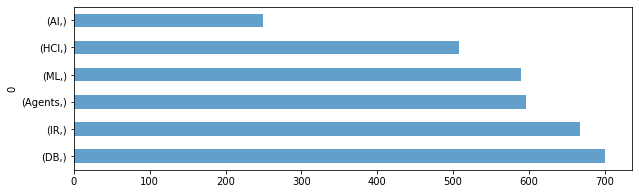

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)


Aprés Data Balancing : 
ML        701
IR        701
HCI       701
DB        701
Agents    701
AI        701
dtype: int64



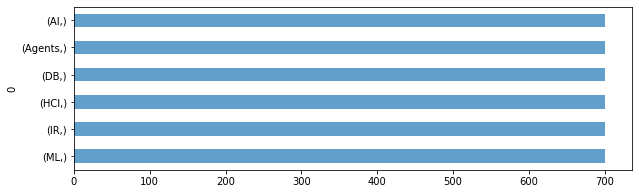

In [ ]:
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(X,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y_train_balanced).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)

#### Data split :

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [ ]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

[1 4 1 ... 4 2 5]


#### Gaussian Naive Bayes :

In [ ]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


Number of mislabeled points out of a total 663 points : 252
Accuracy: 0.6199095022624435


With balanced data :

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Gaussian Naive Bayes",res1,res2))


Number of mislabeled points out of a total 842 points : 203
Accuracy: 0.7589073634204275


#### KNN :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 437
Accuracy: 0.34087481146304677


With balanced data :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("KNN",res1,res2))

Number of mislabeled points out of a total 842 points : 395
Accuracy: 0.5308788598574822


#### LDA : 

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 400
Accuracy: 0.39668174962292607


With balanced data :

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LDA",res1,res2))

Number of mislabeled points out of a total 842 points : 393
Accuracy: 0.5332541567695962


#### QDA :

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 663 points : 553
Accuracy: 0.16591251885369532


In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("QDA",res1,res2))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 842 points : 446
Accuracy: 0.47030878859857483


#### Linear SVM :

#### Linear SVM ( non linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 178
Accuracy: 0.7315233785822021


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("NON Linear SVM",res1,res2))

Number of mislabeled points out of a total 842 points : 168
Accuracy: 0.8004750593824228


#### Linear SVM ( linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 190
Accuracy: 0.7134238310708899


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Linear SVM",res1,res2))

Number of mislabeled points out of a total 842 points : 167
Accuracy: 0.8016627078384798


#### LR :

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 196
Accuracy: 0.7043740573152338


In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LR",res1,res2))

Number of mislabeled points out of a total 842 points : 163
Accuracy: 0.8064133016627079


#### CART :

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 261
Accuracy: 0.6063348416289592


In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("CART",res1,res2))

Number of mislabeled points out of a total 842 points : 210
Accuracy: 0.7505938242280285


#### Random Forest:

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 189
Accuracy: 0.7149321266968326


In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Random Forest",res1,res2))

Number of mislabeled points out of a total 842 points : 153
Accuracy: 0.8182897862232779


#### Resultat : 

In [ ]:
afficher_resultat(resultat_1)

--------------------------
Unbalanced - | -  Balanced 
--------------------------
Gaussian Naive Bayes :
62%         |         76%
--------------------------
KNN :
34%         |         53%
--------------------------
LDA :
40%         |         53%
--------------------------
QDA :
17%         |         47%
--------------------------
NON Linear SVM :
73%         |         80%
--------------------------
Linear SVM :
71%         |         80%
--------------------------
LR :
70%         |         81%
--------------------------
CART :
61%         |         75%
--------------------------
Random Forest :
71%         |         82%
--------------------------


### 2. Une Combinaison des informations W et X tel que M=D^(-1)*W*X : 

#### Matrice W :

W: la matrice d’adjacence (des liens entre les individus) W(n,n)

In [ ]:
W = pd.DataFrame()
list_individus = list(node_list.index)
W = pd.DataFrame(index =list_individus,columns=list_individus)  


#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(df_matrix, value=1): 
    df_matrix = df_matrix.fillna(0)
    mat = df_matrix.values
    n = mat.shape[0]
    mat[range(n), range(n)] = value
    return pd.DataFrame(mat,index =list_individus,columns=list_individus)

W = pd_fill_diagonal(W,1)

# #---------- Les liens entre les individus ----------------

def pd_fill_edges(df_matrix): 
  mat = df_matrix.values
  n = mat.shape[0]
  columns = list(df_matrix.columns)
  egdes = G.edges()
  for i in egdes : 
    r , c = i
    #-----------------------------
    try :
      r = int(r)
    except Exception as str_error:
      pass
    #-----------------------------
    try :
      c = int(c)
    except Exception as str_error:
      pass
    if ( r in columns and c in columns):
      df_matrix.loc[r,c] = 1
      df_matrix.loc[c,r] = 1   
  return df_matrix

W = pd_fill_edges(W)
# ------------   print --------------------
W

,100157,100598,105684,11099,114091,11510,115971,117999,120432,126894,128239,130387,157253,164846,164953,165504,172324,17752,184682,186486,187087,18915,1894,19199,192612,196686,196762,198191,206655,210,2102,21158,21655,226296,22863,233063,23381,236095,239748,241799,...,weinstein99agentbased,weng98visionguided,werger00ayllu,wersing00competitive,whittaker00jotmail,wicke99compiling,wiesmann99systematic,wijsen99generalizing,wilensky00digital,wilhelm99introducing,williams01searchable,wills00open,wills01open,wolf00expert,wolpert99general,wolski00design,wolski98fuzzy,wonsever01contextual,wooldridge98intention,wroblewski00analyzing,wu99firstorder,yang00temporal,yao98making,yokoo02secure,youll00impulse,younes00calibrating,yvon94selflearning,zaki00sequence,zaragoza99dynamic,zavrel00information,zhang01evolutionary,zhang01maximum,zhang01personalized,zhang01pvm,zhang99evolving,zhang99query,zhang99situated,zhang99towards,zhou00implementation,455346
100157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100598,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105684,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11099,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114091,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhang99query,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
zhang99situated,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
zhang99towards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
zhou00implementation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
columns = list(W.columns)

r = "bradshaw97introduction"
c = 100157


if ( r in columns):
  print("yes r")

if ( c in columns):
  print("yes c")

if ( r in columns and c in columns):
  print("yes")
num = "1212"
try :
  a = int(num)
  print("aaaaaaaaaaaaaaaaaaa")
except Exception as str_error:
  pass

yes r
yes c
yes
aaaaaaaaaaaaaaaaaaa


In [ ]:
#---------- Verification de l'individus 35 ----------------
from collections import Counter

verif = []
l = W.loc[100157]
print(Counter(l))

ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(str(ind[i]))
verif.sort()    
print(verif)
print(G.edges())

Counter({0: 3300, 1: 12})
['100157', '364207', '38848', 'bradshaw97introduction', 'bylund99coordinating', 'dix01metaagent', 'gray99finding', 'labrou01standardizing', 'labrou99agent', 'nodine98overview', 'nodine99active', 'wagner97artificial']
[('100157', '100157'), ('364207', '100157'), ('38848', '100157'), ('bradshaw97introduction', '100157'), ('bylund99coordinating', '100157'), ('dix01metaagent', '100157'), ('gray99finding', '100157'), ('labrou01standardizing', '100157'), ('labrou99agent', '100157'), ('nodine98overview', '100157'), ('nodine99active', '100157'), ('wagner97artificial', '100157'), ('455651', '100598'), ('marquez00machine', '100598'), ('punyakanok01use', '100598'), ('krasnogor00memetic', '101570'), ('131669', '10227'), ('sima00computational', '10227'), ('sima01computational', '10227'), ('140169', '103027'), ('weiss00building', '105684'), ('104129', '106003'), ('singhal99document', '106003'), ('amer-yahia00boundingschemas', '106339'), ('arlein99making', '106339'), ('cluet

#### Matrice D et D^-1:

D est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne de W

In [ ]:
D = pd.DataFrame()
D = pd.DataFrame(index =range(0,len(list_individus)),columns=range(0,len(list_individus))) 


#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(d,w): 
    mat = d.values
    n = mat.shape[0]
    mat[range(n), range(n)] = w.sum(axis=1)
    df_matrix = pd.DataFrame(mat,index =list_individus,columns=list_individus)
    df_matrix = df_matrix.fillna(0)
    return df_matrix

D = pd_fill_diagonal(D,W)
#------------------ D^-1 --------------------------
D_1 = 1/D
D_1.replace([np.inf, -np.inf], np.nan, inplace=True)
D_1.fillna(0,inplace=True)
D

,100157,100598,105684,11099,114091,11510,115971,117999,120432,126894,128239,130387,157253,164846,164953,165504,172324,17752,184682,186486,187087,18915,1894,19199,192612,196686,196762,198191,206655,210,2102,21158,21655,226296,22863,233063,23381,236095,239748,241799,...,weinstein99agentbased,weng98visionguided,werger00ayllu,wersing00competitive,whittaker00jotmail,wicke99compiling,wiesmann99systematic,wijsen99generalizing,wilensky00digital,wilhelm99introducing,williams01searchable,wills00open,wills01open,wolf00expert,wolpert99general,wolski00design,wolski98fuzzy,wonsever01contextual,wooldridge98intention,wroblewski00analyzing,wu99firstorder,yang00temporal,yao98making,yokoo02secure,youll00impulse,younes00calibrating,yvon94selflearning,zaki00sequence,zaragoza99dynamic,zavrel00information,zhang01evolutionary,zhang01maximum,zhang01personalized,zhang01pvm,zhang99evolving,zhang99query,zhang99situated,zhang99towards,zhou00implementation,455346
100157,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100598,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105684,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11099,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114091,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhang99query,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
zhang99situated,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
zhang99towards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
zhou00implementation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#---------- Verification de D sur l'individus 31336 & 1061127 ----------------
verif = []
l = W.loc[100157]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(str(ind[i]))
verif.sort()
print("l'individus 100157   : ",len(verif)," liens ")


l'individus 100157   :  12  liens 


In [ ]:
D_1

,100157,100598,105684,11099,114091,11510,115971,117999,120432,126894,128239,130387,157253,164846,164953,165504,172324,17752,184682,186486,187087,18915,1894,19199,192612,196686,196762,198191,206655,210,2102,21158,21655,226296,22863,233063,23381,236095,239748,241799,...,weinstein99agentbased,weng98visionguided,werger00ayllu,wersing00competitive,whittaker00jotmail,wicke99compiling,wiesmann99systematic,wijsen99generalizing,wilensky00digital,wilhelm99introducing,williams01searchable,wills00open,wills01open,wolf00expert,wolpert99general,wolski00design,wolski98fuzzy,wonsever01contextual,wooldridge98intention,wroblewski00analyzing,wu99firstorder,yang00temporal,yao98making,yokoo02secure,youll00impulse,younes00calibrating,yvon94selflearning,zaki00sequence,zaragoza99dynamic,zavrel00information,zhang01evolutionary,zhang01maximum,zhang01personalized,zhang01pvm,zhang99evolving,zhang99query,zhang99situated,zhang99towards,zhou00implementation,455346
100157,0.083333,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100598,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105684,0.000000,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11099,0.000000,0.00,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114091,0.000000,0.00,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhang99query,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
zhang99situated,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
zhang99towards,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
zhou00

#### M :

M=D^(-1)WX : (n,n)*(n,n)*(n,d) => (n,d)

In [ ]:
M = D_1.dot(W)
M = M.dot(X)
M

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3663,3664,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3682,3683,3684,3685,3686,3687,3688,3689,3690,3691,3692,3693,3694,3695,3696,3697,3698,3699,3700,3701,3702
100157,0.0,0.083333,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.166667,0.083333,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100598,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105684,0.0,0.500000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.5,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11099,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114091,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhang99query,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zhang99situated,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zhang99towards,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zhou00implementation,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.

#### Data Balancing :

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(M,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())

Avant Data Balancing : 
DB        701
IR        668
Agents    596
ML        590
HCI       508
AI        249
dtype: int64

Aprés Data Balancing : 
ML        701
IR        701
HCI       701
DB        701
Agents    701
AI        701
dtype: int64


#### Data split :

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [ ]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

[1 4 1 ... 4 2 5]


#### Gaussian Naive Bayes :

In [ ]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


Number of mislabeled points out of a total 663 points : 190
Accuracy: 0.7134238310708899


With balanced data :

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Gaussian Naive Bayes",res1,res2))


Number of mislabeled points out of a total 842 points : 162
Accuracy: 0.8076009501187649


#### KNN :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 248
Accuracy: 0.6259426847662142


With balanced data :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("KNN",res1,res2))

Number of mislabeled points out of a total 842 points : 245
Accuracy: 0.7090261282660333


#### LDA : 

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 355
Accuracy: 0.4645550527903469


With balanced data :

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LDA",res1,res2))

Number of mislabeled points out of a total 842 points : 306
Accuracy: 0.6365795724465558


#### QDA :

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 663 points : 554
Accuracy: 0.16440422322775264


In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("QDA",res1,res2))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 842 points : 273
Accuracy: 0.6757719714964371


#### Linear SVM :

#### Linear SVM ( non linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 158
Accuracy: 0.7616892911010558


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("NON Linear SVM",res1,res2))

Number of mislabeled points out of a total 842 points : 183
Accuracy: 0.7826603325415677


#### Linear SVM ( linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 194
Accuracy: 0.7073906485671192


In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Linear SVM",res1,res2))

Number of mislabeled points out of a total 842 points : 172
Accuracy: 0.7957244655581948


#### LR :

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 172
Accuracy: 0.7405731523378583


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LR",res1,res2))

Number of mislabeled points out of a total 842 points : 146
Accuracy: 0.8266033254156769


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### CART :

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 239
Accuracy: 0.6395173453996983


In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("CART",res1,res2))

Number of mislabeled points out of a total 842 points : 198
Accuracy: 0.7648456057007126


#### Random Forest:

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 663 points : 170
Accuracy: 0.7435897435897436


In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Random Forest",res1,res2))

Number of mislabeled points out of a total 842 points : 134
Accuracy: 0.8408551068883611


#### Resultat : 

In [ ]:
afficher_resultat(resultat_2)

--------------------------
Unbalanced - | -  Balanced 
--------------------------
Gaussian Naive Bayes :
71%         |         81%
--------------------------
KNN :
63%         |         71%
--------------------------
LDA :
46%         |         64%
--------------------------
QDA :
16%         |         68%
--------------------------
NON Linear SVM :
76%         |         78%
--------------------------
Linear SVM :
71%         |         80%
--------------------------
LR :
74%         |         83%
--------------------------
CART :
64%         |         76%
--------------------------
Random Forest :
74%         |         84%
--------------------------


### Comparaison des resultats de X et de M : 

In [ ]:
comparer_resultat(resultat_1,resultat_2)

Gaussian Naive Bayes  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  62%         |         76%
Resultat M :  71%         |         81%
---------------------------------------------
KNN  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  34%         |         53%
Resultat M :  63%         |         71%
---------------------------------------------
LDA  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  40%         |         53%
Resultat M :  46%         |         64%
---------------------------------------------
QDA  :
            Unbalanced    |      Balanced 
---------------------------------------------
Resultat X :  17%         |         47%
Resultat M :  16%         |         68%
---------------------------------------------
NON Linear SVM  :
            Unbalanced    |      Balanced 
----------------------------------

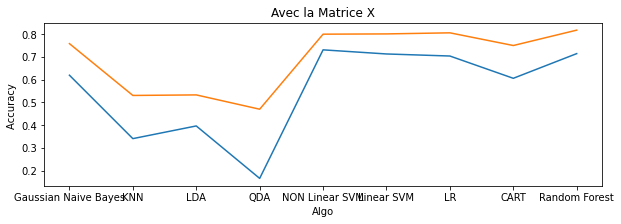

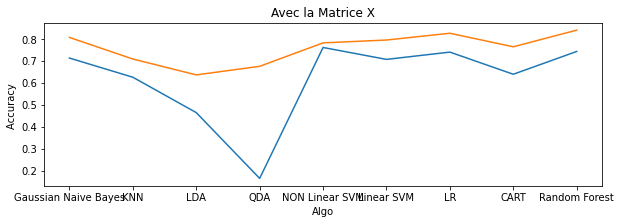

In [ ]:
plt.title('Avec la Matrice X')
plt.xlabel('Algo')
plt.ylabel('Accuracy ')
plt.plot(*zip(*resultat_1))
plt.show()

print()

plt.title('Avec la Matrice X')
plt.xlabel('Algo')
plt.ylabel('Accuracy ')
plt.plot(*zip(*resultat_2))
plt.show()

## ---------------------------------------------------------------------

## III- PubMed:

### Loading Data :

In [ ]:
dataset = sg.datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()


In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)


In [ ]:
print("- La taille du réseau de citations (The citation network) : ",len(G.edges()))
print("- Format du réseau de citations : paper-cites->paper")
print("- Exemple sur une publication et une partie de ses liens :" )
for i in range(0,10):
  print(G.edges()[i])

- La taille du réseau de citations (The citation network) :  44338
- Format du réseau de citations : paper-cites->paper
- Exemple sur une publication et une partie de ses liens :
(19127292, 17363749)
(19668377, 17293876)
(1313726, 3002783)
(19110882, 14578298)
(18606979, 10333910)
(19735543, 8420806)
(19228402, 17017752)
(19220880, 12734781)
(16595006, 11790819)
(19143817, 11206408)


In [ ]:
node_subjects.value_counts().to_frame()

,label
2,7875
3,7739
1,4103


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support.

<Figure size 720x216 with 0 Axes>

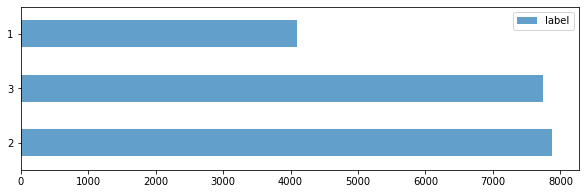

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10,3)
a = node_subjects.value_counts().to_frame()
plt.figure()
a.plot(kind="barh",alpha=0.7)


 Pie plot :


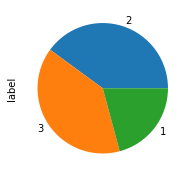

In [ ]:
print(" Pie plot :")
plt.figure()
a["label"].plot(kind="pie")

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)

sampling_strategy='minority' => This means that if the majority class had 1,000 examples and the minority class had 100, this strategy would oversampling the minority class so that it has 1,000 examples.

sampling_strategy=0.5 => This would ensure that the minority class was oversampled to have half the number of examples as the majority class, for binary classification problems. This means that if the majority class had 1,000 examples and the minority class had 100, the transformed dataset would have 500 examples of the minority class.




In [95]:
import scipy.io
mat = scipy.io.loadmat('pubmed.mat')
#--------------------------------------------------------
liste = mat['gnd'].tolist()
subject = [item for sublist in liste for item in sublist]
#--------------------------------------------------------
feature_names = ["w_{}".format(ii) for ii in range(3703)]
column_names = feature_names + ["subject"]
#--------------------------------------------------------
node_list = pd.DataFrame()
node_list["subject"] = subject
node_list["features"] = mat['fea'].tolist()
#node_list["id"] = node_list.index
node_list.head(5)


,subject,features
0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00499937..."
1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01643410..."
2,1,"[0.10463634133338928, 0.0, 0.0, 0.0, 0.0351784..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00858225..."
4,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00735621..."


### 1. Uniquement l’information contenue dans la matrice  X :

In [96]:
X = np.array(list(node_list['features']))
y = np.array(list(node_list['subject']))
resultat_1 = []
resultat_2 = []

#### Data Balancing :

Avant Data Balancing : 
3    7875
2    7739
1    4103
dtype: int64



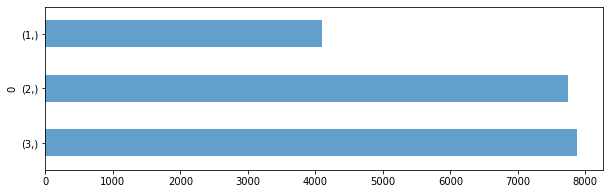

In [97]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)


Aprés Data Balancing : 
3    7875
2    7875
1    7875
dtype: int64



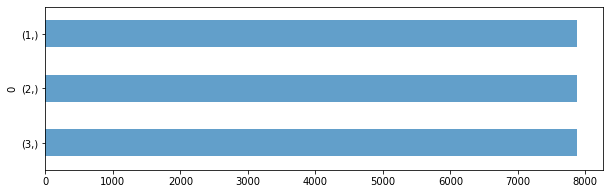

In [98]:
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(X,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())
print()
plt.rcParams["figure.figsize"] = (10,3)
a = pd.DataFrame(y_train_balanced).value_counts()
plt.figure()
a.plot(kind="barh",alpha=0.7)

#### Data split :

In [99]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [100]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

[1 1 0 ... 2 0 2]


#### Gaussian Naive Bayes :

In [101]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


Number of mislabeled points out of a total 3944 points : 899
Accuracy: 0.7720588235294118


With balanced data :

In [102]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Gaussian Naive Bayes",res1,res2))


Number of mislabeled points out of a total 4725 points : 996
Accuracy: 0.7892063492063492


#### KNN :

In [103]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 882
Accuracy: 0.776369168356998


With balanced data :

In [104]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("KNN",res1,res2))

Number of mislabeled points out of a total 4725 points : 947
Accuracy: 0.7995767195767196


#### LDA : 

In [105]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 526
Accuracy: 0.8666328600405679


With balanced data :

In [106]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LDA",res1,res2))

Number of mislabeled points out of a total 4725 points : 591
Accuracy: 0.8749206349206349


#### QDA :

In [107]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 3944 points : 812
Accuracy: 0.7941176470588235


In [108]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("QDA",res1,res2))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Number of mislabeled points out of a total 4725 points : 880
Accuracy: 0.8137566137566138


#### Linear SVM :

#### Linear SVM ( non linear ) :

In [109]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 504
Accuracy: 0.8722109533468559


In [110]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("NON Linear SVM",res1,res2))

Number of mislabeled points out of a total 4725 points : 634
Accuracy: 0.8658201058201058


#### Linear SVM ( linear ) :

In [111]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 475
Accuracy: 0.8795638945233266


In [112]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Linear SVM",res1,res2))

Number of mislabeled points out of a total 4725 points : 534
Accuracy: 0.886984126984127


#### LR :

In [113]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 524
Accuracy: 0.8671399594320487


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [114]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("LR",res1,res2))

Number of mislabeled points out of a total 4725 points : 604
Accuracy: 0.8721693121693121


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### CART :

In [115]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 685
Accuracy: 0.8263184584178499


In [116]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("CART",res1,res2))

Number of mislabeled points out of a total 4725 points : 671
Accuracy: 0.857989417989418


#### Random Forest:

In [117]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

Number of mislabeled points out of a total 3944 points : 420
Accuracy: 0.8935091277890467


In [118]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_1.append(("Random Forest",res1,res2))

Number of mislabeled points out of a total 4725 points : 406
Accuracy: 0.914074074074074


#### Resultat : 

In [119]:
afficher_resultat(resultat_1)

--------------------------
Unbalanced - | -  Balanced 
--------------------------
Gaussian Naive Bayes :
77%         |         79%
--------------------------
KNN :
78%         |         80%
--------------------------
LDA :
87%         |         87%
--------------------------
QDA :
79%         |         81%
--------------------------
NON Linear SVM :
87%         |         87%
--------------------------
Linear SVM :
88%         |         89%
--------------------------
LR :
87%         |         87%
--------------------------
CART :
83%         |         86%
--------------------------
Random Forest :
89%         |         91%
--------------------------


### 2. Une Combinaison des informations W et X tel que M=D^(-1)*W*X : 

#### Matrice W :

W: la matrice d’adjacence (des liens entre les individus) W(n,n)

In [1]:
W = pd.DataFrame()
list_individus = list(node_list.index)
W = pd.DataFrame(index =list_individus,columns=list_individus)  

#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(df_matrix, value=0): 
    df_matrix = df_matrix.fillna(0)
    mat = df_matrix.values
    n = mat.shape[0]
    mat[range(n), range(n)] = value
    return pd.DataFrame(mat,index =list_individus,columns=list_individus)

W = pd_fill_diagonal(W,1)

# #---------- Les liens entre les individus ----------------

def pd_fill_edges(df_matrix): 
  mat = df_matrix.values
  n = mat.shape[0]
  columns = df_matrix.columns
  indexes = df_matrix.index
  egdes = G.edges()
  for i in egdes : 
    r , c = i
    df_matrix.at[r,c] = 1
    df_matrix.at[c,r] = 1

  df_matrix = df_matrix.fillna(0)

  return df_matrix
W = pd_fill_edges(W)

# ------------   print --------------------
W

NameError: ignored

In [ ]:
#---------- Verification de l'individus 35 ----------------

verif = []
l = W.loc[35]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print(verif)
print(G.edges())

#### Matrice D et D^-1:

D est une matrice diagonale, chaque valeur diagonale correspond à la somme des valeurs d’une ligne de W

In [ ]:
D = pd.DataFrame()
D = pd.DataFrame(index =range(0,len(list_individus)),columns=range(0,len(list_individus))) 


#------------------  Diagonal à 1 ----------------
def pd_fill_diagonal(d,w): 
    mat = d.values
    n = mat.shape[0]
    mat[range(n), range(n)] = w.sum(axis=1)
    df_matrix = pd.DataFrame(mat,index =list_individus,columns=list_individus)
    df_matrix = df_matrix.fillna(0)
    return df_matrix

D = pd_fill_diagonal(D,W)
#------------------ D^-1 --------------------------
D_1 = 1/D
D_1.replace([np.inf, -np.inf], np.nan, inplace=True)
D_1.fillna(0,inplace=True)
D

In [ ]:
#---------- Verification de D sur l'individus 31336 & 1061127 ----------------
verif = []
l = W.loc[31336]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print("l'individus 31336   : ",len(verif)," liens ")
#------------------------------------------------------------------------------
verif = []
l = W.loc[1061127]
ind, val = l.index,l.values
for i in range(0,len(ind)):
  if val[i]==1:
    verif.append(ind[i])
verif.sort()
print("l'individus 1061127 : ",len(verif)," liens ")

In [ ]:
D_1

#### M :

M=D^(-1)WX : (n,n)*(n,n)*(n,d) => (n,d)

In [ ]:
M = D_1.dot(W)
M = M.dot(X)
M

#### Data Balancing :

In [ ]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(random_state=0)
ydf = pd.DataFrame(y)
print("Avant Data Balancing : ")
print(ydf.value_counts())
print()
# fit and apply the transform
X_train_balanced,y_train_balanced = oversample.fit_resample(M,y)
# summarize class distribution
ydf = pd.DataFrame(y_train_balanced)
print("Aprés Data Balancing : ")
print(ydf.value_counts())

#### Data split :

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size=0.2,random_state=0) # 70% training and 30% test

#--------------------------------------------------------------------------------------------------------------------

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2,random_state=0) # 70% training and 30% test


#### Label encoder :

In [ ]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_encoded=le.fit_transform(y)
print(y_encoded)

#### Gaussian Naive Bayes :

In [ ]:
from sklearn import metrics

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)


With balanced data :

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_balanced, y_train_balanced)

#Predict the response for test dataset
y_pred_balanced = gnb.predict(X_test_balanced)


print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Gaussian Naive Bayes",res1,res2))


#### KNN :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train, y_train)
#Predict Output
y_pred= modelknn.predict(X_test) # 0:Overcast, 2:Mild

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

With balanced data :

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
modelknn.fit(X_train_balanced, y_train_balanced)
#Predict Output
y_pred_balanced= modelknn.predict(X_test_balanced) 

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("KNN",res1,res2))

#### LDA : 

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train, y_train)
y_pred= modelLDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

With balanced data :

In [ ]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LDA",res1,res2))

#### QDA :

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train, y_train)
y_pred= modelQDA.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelQDA.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?

res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("QDA",res1,res2))

#### Linear SVM :

#### Linear SVM ( non linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?

res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='sigmoid'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("NON Linear SVM",res1,res2))

#### Linear SVM ( linear ) :

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train, y_train)
y_pred= modelSVM.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
modelSVM.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelSVM.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Linear SVM",res1,res2))

#### LR :

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train, y_train)
y_pred= modelLR.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelLR = LogisticRegression(random_state=0)
modelLR.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelLR.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("LR",res1,res2))

#### CART :

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train, y_train)
y_pred= modelCART.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelCART = tree.DecisionTreeClassifier()
modelCART.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelCART.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("CART",res1,res2))

#### Random Forest:

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train, y_train)
y_pred= modelRF.predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
# Model Accuracy, how often is the classifier correct?
res1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",res1)

In [ ]:
modelRF = RandomForestClassifier(max_depth=100, random_state=0)
modelRF.fit(X_train_balanced, y_train_balanced)
y_pred_balanced= modelRF.predict(X_test_balanced)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_balanced.shape[0], (y_test_balanced != y_pred_balanced).sum()))
# Model Accuracy, how often is the classifier correct?
res2 = metrics.accuracy_score(y_test_balanced, y_pred_balanced)
print("Accuracy:",res2)
resultat_2.append(("Random Forest",res1,res2))

#### Resultat : 

In [ ]:
afficher_resultat(resultat_2)

### Comparaison des resultats de X et de M : 

In [ ]:
comparer_resultat(resultat_1,resultat_2)